In [6]:
from numpy.fft import fft, ifft, hfft
from scipy.signal import lfilter
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from IPython.display import Audio
from scipy import signal
from helpers import *

figsize=(10,5)

In [7]:
fs=44100

In [8]:
def gain_computer(x_G, T, W, R):
    """
    Gain computer returning all values of y_G[n] in dB for all x_G[n] in dB.
    """
    y_G = np.zeros(x_G.size) # init y_G
    y_G = np.where(2 * (x_G - T) < -W,       x_G, y_G) # Compression off level range
    y_G = np.where(2 * np.abs(x_G - T) <= W, x_G + (1/R - 1)*(x_G - T + W/2)**2 / (2*W), y_G) # Soft-knee range
    y_G = np.where(2 * (x_G - T) > W,        T + (x_G - T)/R,  y_G) # Compression on range
    
    return y_G

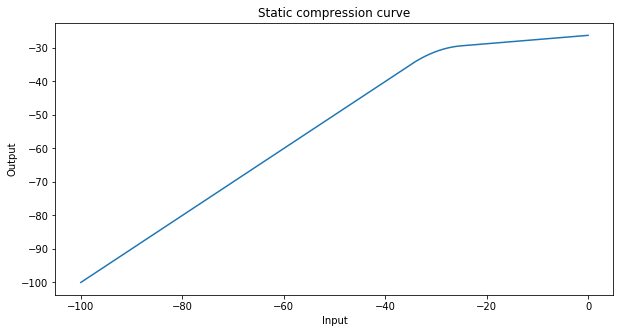

In [9]:
plt.figure(figsize=figsize)
compression_curve= gain_computer(np.linspace(-100, 0, 200000), T=-30, W=10, R=8)
plt.plot(np.linspace(-100, 0, 200000), compression_curve)
plt.xlabel("Input")
plt.ylabel("Output")
plt.title("Static compression curve")
plt.show()

In [10]:
def peak_detector(x_L, attack, release):
    """
    Peak detector computing Y_L in dB based on X_L in dB.
    """
    y_L = np.copy(x_L) # init Y_L
    
    for n in range(1, x_L.size):
        if x_L[n] > y_L[n-1] :
            y_L[n] = attack * y_L[n-1] + (1-attack) * x_L[n]
        else:
            y_L[n] = release * y_L[n-1] + (1-release) * x_L[n]

    return y_L

<function matplotlib.pyplot.show(*args, **kw)>

C:\Python\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


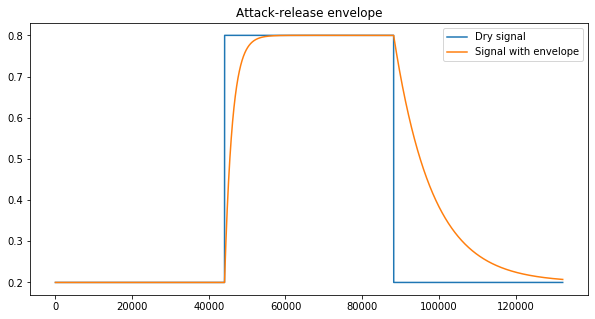

In [11]:
plt.figure(figsize=figsize)
square = 0.2 * np.ones(3*fs)
square[1*fs:2*fs] = 0.8
plt.plot(square, label="Dry signal")
plt.plot(peak_detector(square, 0.9995, 0.9999) , label="Signal with envelope")
plt.title("Attack-release envelope")
plt.legend()
plt.show

In [12]:
def time_to_coef(attack_time, release_time):
    """
    Convert the attack and release times into attack and release coefficients.
    """
    return np.exp(-1/(attack_time*fs)), np.exp(-1/(release_time*fs))

In [13]:
def compressor(x, T=-30, W=.1, R=4, M=20, at=.001, rt=.01):

    x_G = np.where(20 * np.log10(np.abs(x)) > -100, 20 * np.log10(np.abs(x)), -100) # conversion to dB
    y_G = gain_computer(x_G, T, W, R) 
    
    attack, release = time_to_coef(at, rt) # Convert times to coefs
    x_L =  y_G - x_G
    y_L = peak_detector(x_L, attack, release)
    
    x_M = M + y_L
    sidechain = np.power(10, x_M / 20) # conversion back to linear
    
    return x * sidechain

# Guitar sample

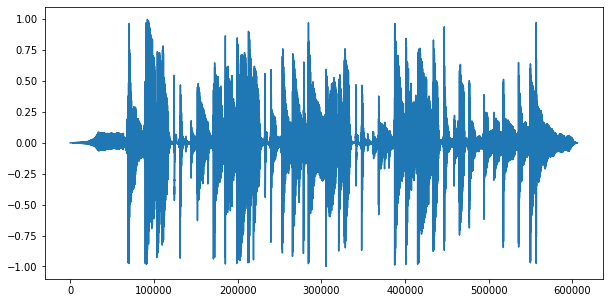

In [14]:
fs, data = wavfile.read('samples/guitar.wav')
guitar_sample = np.array(data, dtype=np.float32)
guitar_sample /= np.max(np.abs(guitar_sample) )
plt.figure(figsize=figsize)
plt.plot(guitar_sample)
Audio("samples/guitar.wav", autoplay=False)

C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


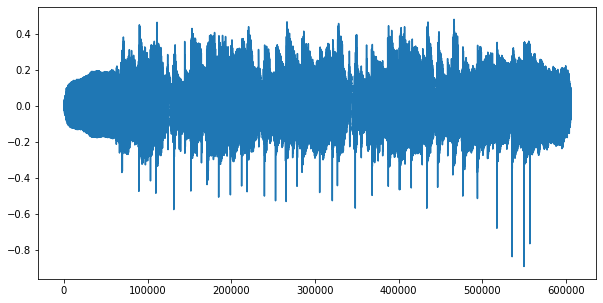

In [21]:
guitar_comp = compressor(guitar_sample, T=-60, W=20, R=8, M=40, at=.01, rt=.0002)

plt.figure(figsize=figsize)
plt.plot(guitar_comp);


In [26]:
wavfile.write('samples/guitar_comp.wav', fs, (0x7FFF * guitar_comp).astype(np.int16))
Audio("samples/guitar_comp.wav", autoplay=False)